In [3]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

from dataset import Dataset
from model import StockPriceModelRNN, StockPriceModelARN, StockPriceModelTransformer

path = 'model_rnn_01-28-2023_17-32-09/'

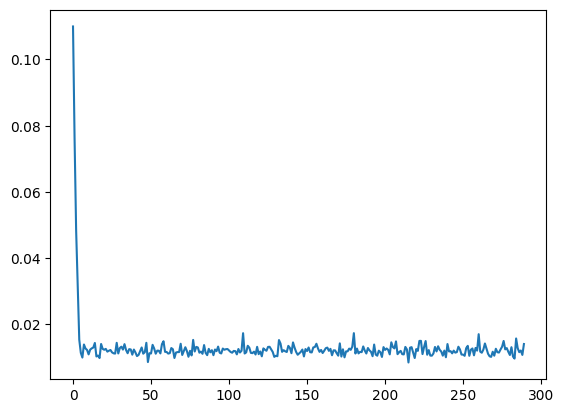

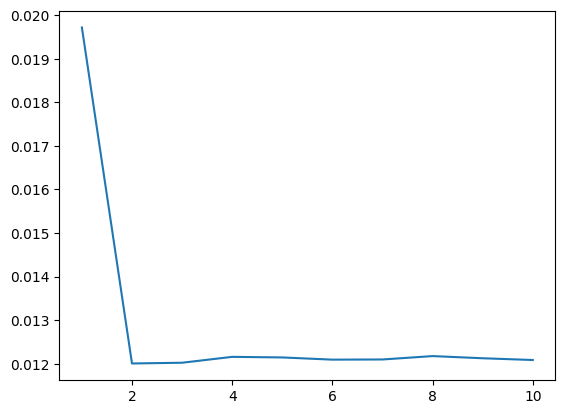

In [4]:
loss = pd.read_csv(path + 'train_loss.csv', sep=';')
plt.plot(loss['MAE'])
plt.show()

epoch_loss = loss.groupby('epoch')['MAE'].mean()
plt.plot(epoch_loss)
plt.show()

In [5]:
conf = pd.read_json(path + 'conf.json')
display(conf)

model = StockPriceModelRNN(
    n_news_features=conf.loc[0, 'n_news_features'],
    rnn_n_layers=conf.loc[0, 'rnn_n_layers'],
    rnn_hidden_size=conf.loc[0, 'rnn_hidden_size']
).float()
"""
model = StockPriceModelARN(
    n_news_features=conf.loc[0, 'n_news_features'],
    seq_len=conf.loc[0, 'seq_len']
).float()

model = StockPriceModelTransformer(
    n_news_features=conf.loc[0, 'n_news_features'],
    seq_len=conf.loc[0, 'seq_len']
).float()
"""
model.load_state_dict(torch.load(path + 'model.t7', map_location=torch.device('cpu')))
model.eval()

df = pd.read_csv('../data/dataset.csv', sep=';', index_col='time_stamp')
test_set = Dataset(
    df=df,
    testing=True,
    lag=conf.loc[0, 'lag'],
    seq_len=conf.loc[0, 'seq_len'],
    test_len=1,
)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, drop_last=True)

state = None
y_pred = test_set[0][1]
y_gt = test_set[0][1]
y_zero_pred = test_set[0][1]
with torch.no_grad():
    for batch_idx, (time_stamp, x_price, x_news_input_ids, x_news_attention_mask, y) in enumerate(test_loader):
        #y_price, state = model(x_news_input_ids, x_news_attention_mask, x_price, state)
        y_price, state = model(x_price, x_news_input_ids, x_news_attention_mask, state)
        y_pred = torch.cat((y_pred, y_price), dim=0)
        y_gt = torch.cat((y_gt, y[0, :, :]), dim=0)
        y_zero_pred = torch.cat((y_zero_pred, torch.zeros(1, 1)), dim=0)
    
        if batch_idx > 50:
            break

,batch_size,lr,epochs,n_news_features,rnn_n_layers,rnn_hidden_size,seq_len,lag
0,2,0.0001,10,0,1,16,5,0


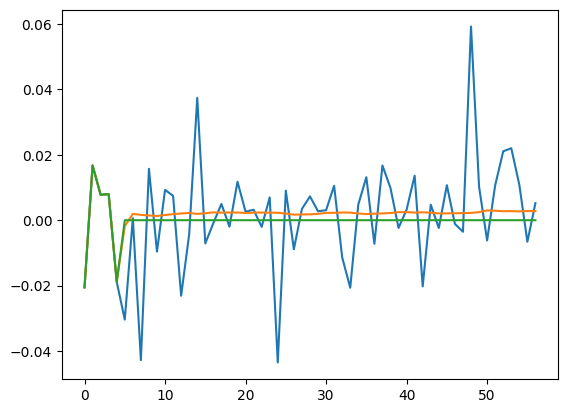

Test Loss: 0.5847170948982239
Zero predictor Loss: 0.60798180103302


In [6]:
plt.plot(y_gt)
plt.plot(y_pred)
plt.plot(y_zero_pred)
plt.show()

test_loss = torch.nn.L1Loss(reduction='sum')
print(f'Test Loss: {test_loss(y_gt, y_pred)}')
print(f'Zero predictor Loss: {test_loss(y_gt, y_zero_pred)}')

In [ ]:
a = torch.randint(1, 10, (10,))
print(a)
print(a[:-1])
print(a[1:])
print(a[::2])